In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from WindPy import w
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
data = w.wsd('DJI.GI', 'close', '1900-01-01', '2019-01-10')

In [7]:
data

.ErrorCode=0
.Codes=[DJI.GI]
.Fields=[CLOSE]
.Times=[19901219,19901220,19901221,19901224,19901225,19901226,19901227,19901228,19901231,19910102,...]
.Data=[[2626.73,2629.46,2633.66,2621.29,2621.29,2637.13,2625.5,2629.21,2633.66,2610.64,...]]

In [8]:
df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=['dji'])

In [12]:
df.head()

,dji,vol
1990-12-19,2626.73,NaN
1990-12-20,2629.46,NaN
1990-12-21,2633.66,NaN
1990-12-24,2621.29,NaN
1990-12-25,2621.29,NaN


In [10]:
df['vol'] = df['dji'].rolling(window=243).std() * np.sqrt(243)

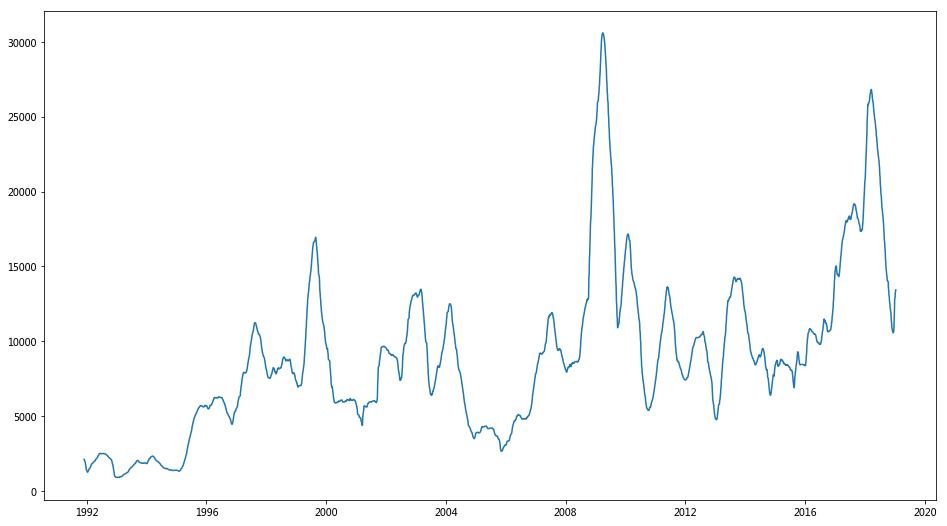

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(df['vol'])

In [54]:
num_bckts

3

In [55]:
pad_size = conf['bckt_size'] * num_bckts - g.size

In [56]:
pad_size

1

In [57]:
g_mat = np.reshape(np.pad(g, (0, pad_size), 'constant',
    constant_values=(0.0, 0.0)), (num_bckts, conf['bckt_size']))

In [58]:
g_mat

array([[1. , 2.2],
       [3. , 4. ],
       [5. , 0. ]])

In [59]:
if conf['use_l2_scl']:
    g_scl = norm(g_mat, axis=1, keepdims=True)  # L2-norm
else:
    g_scl = norm(g_mat, np.inf, axis=1, keepdims=True)  # LInf-norm

In [60]:
g_scl

array([[2.41660919],
       [5.        ],
       [5.        ]])

In [61]:
np.where(np.random.uniform(
    size=g_mat.shape) < np.abs(g_mat) / g_scl)

(array([0, 1, 1, 2], dtype=int64), array([1, 0, 1, 0], dtype=int64))

In [62]:
g_lvl = np.sign(g_mat).astype(np.int8) * np.where(np.random.uniform(
    size=g_mat.shape) < np.abs(g_mat) / g_scl, 1, 0).astype(np.int8)

In [63]:
g_lvl

array([[0, 1],
       [1, 0],
       [1, 0]], dtype=int8)

In [64]:
g_fnl = (g_scl * g_lvl).ravel()[:g.size]

In [65]:
g_fnl

array([0.        , 2.41660919, 5.        , 0.        , 5.        ])

In [66]:
idxs_nnz = np.nonzero(g_fnl)[0]

In [67]:
idxs_nnz

array([1, 2, 4], dtype=int64)

In [68]:
g_enc = np.concatenate(
    (idxs_nnz.size * np.ones((1)), idxs_nnz, g_fnl[idxs_nnz]))

In [69]:
g_enc

array([3.        , 1.        , 2.        , 4.        , 2.41660919,
       5.        , 5.        ])

# quantization

In [126]:
g = np.array([-10.5, -1., 2., 5., 15.])

In [127]:
g

array([-10.5,  -1. ,   2. ,   5. ,  15. ])

In [128]:
factor, bit = 2., 2
bound = np.power(2, bit)
min_val = - bound
max_val = bound - 1

In [129]:
min_val, max_val

(-4, 3)

In [130]:
g_factor = g / factor

In [131]:
g_factor

array([-5.25, -0.5 ,  1.  ,  2.5 ,  7.5 ])

In [132]:
g_floor = np.floor(g_factor)
g_ceil = np.ceil(g_factor)
prob_to_floor = g_factor - g_floor
index = prob_to_floor > np.random.uniform(size=g.size)

In [133]:
g_floor, g_ceil

(array([-6., -1.,  1.,  2.,  7.]), array([-5., -0.,  1.,  3.,  8.]))

In [134]:
g_factor[index] = g_floor[index]

In [135]:
g_factor[~index] = g_ceil[~index]

In [136]:
g_quant = np.clip(g_factor_round, min_val, max_val)

In [137]:
g_quant

array([-4.,  0.,  1.,  2.,  3.])

In [153]:
def quantization(g, factor, bit):
    bound = np.power(2, bit)
    min_val = - bound
    max_val = bound - 1
    
    g_factor = g / factor
    g_floor = np.floor(g_factor)
    g_ceil = np.ceil(g_factor)
    prob_to_floor = g_factor - g_floor
    index = prob_to_floor > np.random.uniform(size=g.size)
    g_factor[index] = g_floor[index]
    g_factor[~index] = g_ceil[~index]
    g_quant = np.clip(g_factor, min_val, max_val)
    return g_quant

In [154]:
quantization(g, 2., 2)

array([-4., -0.,  1.,  2.,  3.])

In [146]:
g_quant.astype(np.int8)

array([-4,  0,  1,  2,  3], dtype=int8)